In [1]:
from tools import load_config
# Import necessary libraries
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from lifelines import CoxPHFitter
from statsmodels.stats.outliers_influence import variance_inflation_factor




# Load the config.yaml
config = load_config("config.yaml")

# Extract the processed data location
processed_data_location = config["processed_data_location"]

# Load the processed data into a DataFrame
import pandas as pd
data = pd.read_csv(processed_data_location)

# Display the DataFrame
data.head()


c:\Users\Danylo\Desktop\MainCategories\MastersDiploma\Practice\program\src\config.yaml


,subjid,sex,vomitfl,vomit_minfrq,vomit_maxfrq,temp,virusfl,hosp_days,age_years,antibioticfl,probioticfl,analgesicfl,treatment_combination,combination_description,dehsev_Mild dehydration,dehsev_No dehydration,dehsev_Severe dehydration,BMI
0,1,2,1,2.0,3.0,37.8,1,3,0.393607,0,0,0,0,No treatments,False,False,True,13.611111
1,2,1,1,3.0,4.0,39.0,1,3,1.893607,0,0,0,0,No treatments,True,False,False,13.442554
2,3,1,0,NaN,NaN,37.1,1,5,1.868950,0,0,0,0,No treatments,True,False,False,19.333730
3,4,2,1,2.0,3.0,37.7,1,2,0.657306,0,0,1,1,Analgesic only,False,False,True,16.568047
4,7,1,1,1.0,2.0,36.5,1,1,0.885388,0,0,0,0,No treatments,False,False,True,11.108907


In [2]:
data.columns = data.columns.str.strip().str.replace(" ", "_")

In [3]:
data.columns 

Index(['subjid', 'sex', 'vomitfl', 'vomit_minfrq', 'vomit_maxfrq', 'temp',
       'virusfl', 'hosp_days', 'age_years', 'antibioticfl', 'probioticfl',
       'analgesicfl', 'treatment_combination', 'combination_description',
       'dehsev_Mild_dehydration', 'dehsev_No_dehydration',
       'dehsev_Severe_dehydration', 'BMI'],
      dtype='object')

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
import pandas as pd

from sklearn.impute import SimpleImputer


# Prepare the data
unique_treatment_combinations = data['treatment_combination'].unique()
covariates = [
    'age_years', 'sex', 'BMI', 'temp', 
    'vomitfl', 'virusfl', 
    'dehsev_Mild_dehydration', 
    'dehsev_Severe_dehydration',
    'dehsev_No_dehydration',
     'vomit_avgfrq'
]

imputer = SimpleImputer(strategy='mean')  # Replace 'mean' with 'median' or other strategies if needed
data[covariates] = imputer.fit_transform(data[covariates])



scaler = StandardScaler()
X = scaler.fit_transform(data[covariates])

def psm(data, X, treatment_combinations):
    """
    Perform Propensity Score Matching (PSM) for multiple treatment groups.
    
    Parameters:
        data (pd.DataFrame): The dataset containing the treatment and covariate data.
        X (np.ndarray): Scaled covariates used to estimate propensity scores.
        treatment_combinations (list): List of unique treatment combinations.
        
    Returns:
        dict: Dictionary where each treatment group is mapped to its matched pairs dataframe.
    """
    binary_psm_results = {}
    
    for treatment_group in treatment_combinations:
        # Create binary treatment variable
        data['binary_treatment'] = (data['treatment_combination'] == treatment_group).astype(int)
        
        # Estimate propensity scores for the binary treatment
        logreg = LogisticRegression(max_iter=1000)
        logreg.fit(X, data['binary_treatment'])
        data['propensity_score'] = logreg.predict_proba(X)[:, 1]
        
        # Perform nearest-neighbor matching
        treated_idx = data[data['binary_treatment'] == 1].index
        control_idx = data[data['binary_treatment'] == 0].index
        
        nn = NearestNeighbors(n_neighbors=1)
        nn.fit(data.loc[control_idx, 'propensity_score'].values.reshape(-1, 1))
        distances, neighbors = nn.kneighbors(
            data.loc[treated_idx, 'propensity_score'].values.reshape(-1, 1)
        )
        
        # Store matched pairs
        matched_pairs = pd.DataFrame({
            'treated': treated_idx,
            'matched': control_idx[neighbors.flatten()],
            'distance': distances.flatten()
        })
        
        binary_psm_results[treatment_group] = matched_pairs
    
    return binary_psm_results

def evaluate_balance(matched_pairs, data, covariates):
    """
    Evaluate covariate balance for matched pairs.
    
    Parameters:
        matched_pairs (pd.DataFrame): DataFrame containing treated and matched indices.
        data (pd.DataFrame): The original dataset containing covariates.
        covariates (list): List of covariate column names.
        
    Returns:
        pd.DataFrame: DataFrame with covariates and their standardized differences.
    """
    balance = []
    for cov in covariates:
        treated_vals = data.loc[matched_pairs['treated'], cov].values
        matched_vals = data.loc[matched_pairs['matched'], cov].values
        standardized_diff = (treated_vals.mean() - matched_vals.mean()) / data[cov].std()
        balance.append({'Covariate': cov, 'Standardized Difference': standardized_diff})
    return pd.DataFrame(balance)

# Perform PSM
binary_psm_results = psm(data, X, unique_treatment_combinations)

# Evaluate balance for one of the groups
selected_group = unique_treatment_combinations[1]  # Pick any group to analyze
selected_matched_pairs = binary_psm_results[selected_group]

# Calculate covariate balance
balance = evaluate_balance(selected_matched_pairs, data, covariates)


KeyError: "['vomit_avgfrq'] not in index"

In [ ]:
balance

,Covariate,Standardized Difference
0,age_years,0.030923
1,sex,-0.021294
2,BMI,-0.151163
3,temp,0.120811
4,vomitfl,-0.049660
5,virusfl,0.000000
6,dehsev_Mild_dehydration,-0.074882
7,dehsev_Severe_dehydration,0.038306
8,dehsev_No_dehydration,0.059322
9,vomit_avgfrq,0.077568


In [ ]:
combination_mapping = {
    '000': 'Без лікування',
    '100': 'Тільки антибіотик',
    '010': 'Тільки пробіотик',
    '001': 'Тільки анальгетик',
    '110': 'Антибіотик і пробіотик',
    '101': 'Антибіотик і анальгетик',
    '011': 'Пробіотик і анальгетик',
    '111': 'Усі три види лікування'
}


In [ ]:
combination_mapping['0'] = 'Без лікування'


In [ ]:
combination_mapping.update({
    '1': 'Тільки пробіотик',
    '10': 'Тільки анальгетик',
    '11': 'Пробіотик і анальгетик'
})

In [ ]:
# Function to calculate and collect balance for all treatment groups
def calculate_all_balances(psm_results, data, covariates):
    """
    Calculate covariate balance for all treatment groups.
    
    Parameters:
        psm_results (dict): Dictionary of matched pairs for each treatment group.
        data (pd.DataFrame): The original dataset containing covariates.
        covariates (list): List of covariate column names.
        
    Returns:
        pd.DataFrame: DataFrame containing covariate balances for all treatment groups.
    """
    all_balances = []
    for group in psm_results:
        matched_pairs = psm_results[group]
        group_balance = evaluate_balance(matched_pairs, data, covariates)
        group_balance['Treatment Group'] = group
        all_balances.append(group_balance)
    return pd.concat(all_balances, ignore_index=True)

# Perform PSM for all treatment groups
binary_psm_results = psm(data, X, unique_treatment_combinations)

# Evaluate balance for a selected treatment group
selected_group = unique_treatment_combinations[1]  # Pick any group to analyze
selected_matched_pairs = binary_psm_results[selected_group]

# Calculate covariate balance for the selected group
balance = evaluate_balance(selected_matched_pairs, data, covariates)

# Calculate balances for all treatment groups
all_balances = calculate_all_balances(binary_psm_results, data, covariates)


In [ ]:
all_balances

,Covariate,Standardized Difference,Treatment Group
0,age_years,0.085018,0
1,sex,-0.011263,0
2,BMI,0.097255,0
3,temp,-0.019229,0
4,vomitfl,-0.118199,0
...,...,...,...
75,virusfl,0.000000,110
76,dehsev_Mild_dehydration,0.000000,110
77,dehsev_Severe_dehydration,0.000000,110
78,dehsev_No_dehydration,0.000000,110


In [ ]:
# Convert 'Treatment Group' to string before mapping
all_balances['Treatment Group'] = all_balances['Treatment Group'].astype(str)
all_balances['Treatment Group Name'] = all_balances['Treatment Group'].map(combination_mapping)


In [ ]:
covariate_mapping = {
    'age_years': 'Вік (роки)',
    'sex': 'Стать',
    'BMI': 'ІМТ (Індекс маси тіла)',
    'temp': 'Температура',
    'vomitfl': 'Блювота',
    'virusfl': 'Вірусна інфекція',
    'dehsev_Mild_dehydration': 'Легке зневоднення',
    'dehsev_Severe_dehydration': 'Важке зневоднення',    
    'dehsev_No_dehydration': 'Немає зневоднення',
    "vomit_avgfrq" : 'Середня частота блювання'
}

# Перейменування коваріатів в даних
all_balances['Covariate'] = all_balances['Covariate'].map(covariate_mapping)


In [ ]:
# Identify any treatment groups that were not mapped (if any)
unmapped_groups = data[data['treatment_combination'].isna()]['treatment_combination'].unique()
if len(unmapped_groups) > 0:
    print("\nUnmapped treatment groups found:")
    print(unmapped_groups)
else:
    print("\nAll treatment groups mapped successfully.")


All treatment groups mapped successfully.


In [ ]:
# Define the selected treatment groups as integers
selected_groups = [0, 10, 1, 100]  # Corresponding to '000', '010', '001', '100'

# Filter the dataset for the selected treatment groups
filtered_data = data[data['treatment_combination'].isin(selected_groups)].copy()

In [ ]:
# Standardize covariates
scaler = StandardScaler()
X_filtered = scaler.fit_transform(filtered_data[covariates])

# Perform Propensity Score Matching for the selected treatment groups
binary_psm_results = psm(filtered_data, X_filtered, selected_groups)

# Calculate covariate balance for all selected groups using the pre-defined function
all_balances_df = calculate_all_balances(binary_psm_results, filtered_data, covariates)

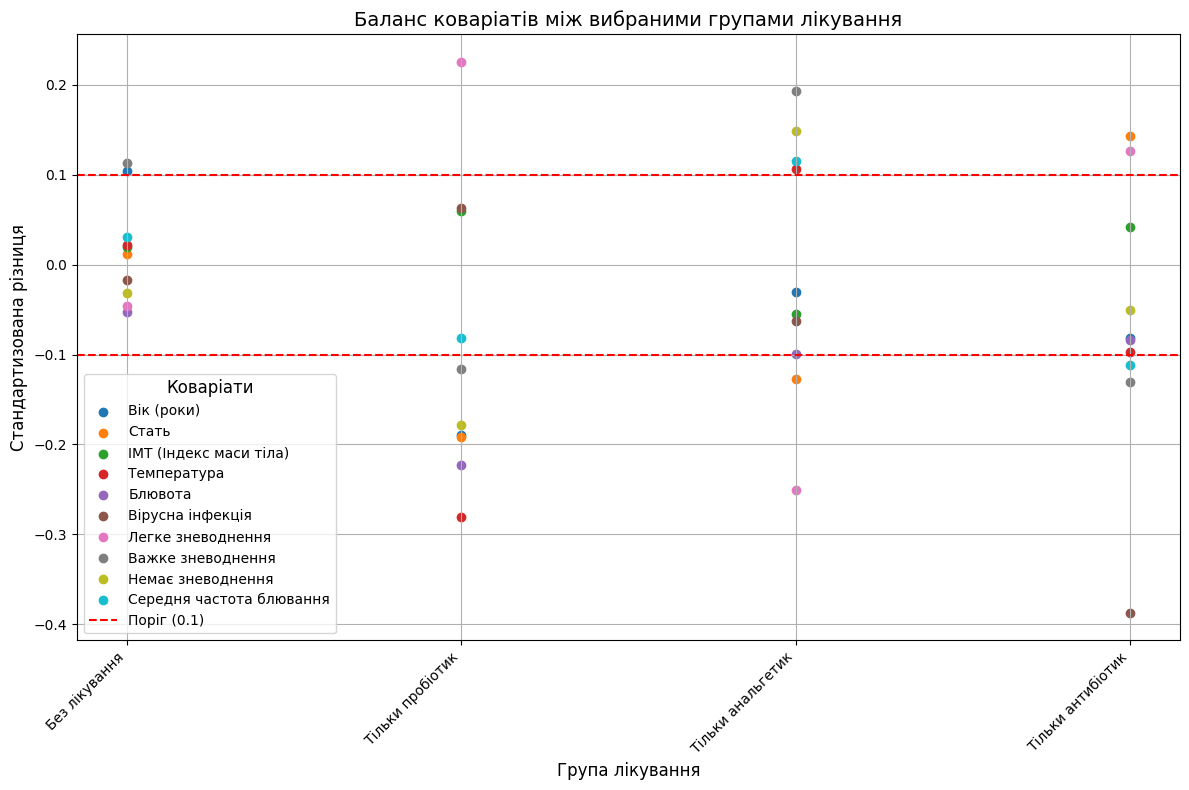

In [ ]:
# Створюємо мапінг для груп лікування
group_mapping = {
    0: 'Без лікування',
    10: 'Тільки пробіотик',
    1: 'Тільки анальгетик',
    100: 'Тільки антибіотик'
}

# Додаємо колонку 'Treatment Group Name' до all_balances_df
all_balances_df['Treatment Group Name'] = all_balances_df['Treatment Group'].map(group_mapping)

# Словник для перекладу коваріатів
covariate_mapping_ukrainian = {
    'age_years': 'Вік (роки)',
    'sex': 'Стать',
    'BMI': 'ІМТ (Індекс маси тіла)',
    'temp': 'Температура',
    'vomitfl': 'Блювота',
    'virusfl': 'Вірусна інфекція',
    'dehsev_Mild_dehydration': 'Легке зневоднення',
    'dehsev_Severe_dehydration': 'Важке зневоднення',    
    'dehsev_No_dehydration': 'Немає зневоднення',
    "vomit_avgfrq" : 'Середня частота блювання'
}

# Оновлюємо колонку 'Covariate Ukrainian' для відображення українських назв
all_balances_df['Covariate Ukrainian'] = all_balances_df['Covariate'].map(covariate_mapping_ukrainian)

# Візуалізація балансу з перекладеними коваріатами
plt.figure(figsize=(12, 8))
for cov in all_balances_df['Covariate Ukrainian'].unique():
    subset = all_balances_df[all_balances_df['Covariate Ukrainian'] == cov]
    plt.scatter(subset['Treatment Group Name'], subset['Standardized Difference'], label=cov)

# Додаткові лінії та деталі графіка
plt.axhline(y=0.1, color='r', linestyle='--', label='Поріг (0.1)')
plt.axhline(y=-0.1, color='r', linestyle='--')
plt.title('Баланс коваріатів між вибраними групами лікування', fontsize=14)
plt.xlabel('Група лікування', fontsize=12)
plt.ylabel('Стандартизована різниця', fontsize=12)
plt.xticks(rotation=45, ha='right')  # Поворот міток на осі X
plt.legend(title='Коваріати', fontsize=10, title_fontsize=12)  # Оновлена легенда
plt.grid(True)
plt.tight_layout()  # Коригування макету
plt.show()


In [ ]:
all_balances_df[['Standardized Difference', 'Covariate Ukrainian']]

,Standardized Difference,Covariate Ukrainian
0,0.103915,Вік (роки)
1,0.011255,Стать
2,0.020067,ІМТ (Індекс маси тіла)
3,0.021375,Температура
4,-0.052474,Блювота
5,-0.016583,Вірусна інфекція
6,-0.046448,Легке зневоднення
7,0.112587,Важке зневоднення
8,-0.031509,Немає зневоднення
9,0.030515,Середня частота блювання


In [ ]:
# Combine all matched pairs from PSM results
all_matched_pairs = pd.concat(
    [binary_psm_results[group] for group in binary_psm_results], 
    ignore_index=True
)


In [ ]:
# Retrieve matched treated and control subjects
matched_treated = data.loc[all_matched_pairs['treated']]
matched_control = data.loc[all_matched_pairs['matched']]

# Combine treated and control subjects into a single DataFrame
matched_subjects = pd.concat([matched_treated, matched_control], ignore_index=True)

# Add a column indicating treatment/control status
matched_subjects['treatment_status'] = ['Treated'] * len(matched_treated) + ['Control'] * len(matched_control)


In [ ]:
# Count the number of subjects by treatment combination
print(matched_subjects['treatment_combination'].value_counts())

# Inspect the matched data
print(matched_subjects.head())


treatment_combination
0      506
1      287
100    173
10     130
Name: count, dtype: int64
   subjid  sex  vomitfl  temp  virusfl  hosp_days  age_years  probioticfl  \
0       1  2.0      1.0  37.8      1.0          3   0.393607            0   
1       2  1.0      1.0  39.0      1.0          3   1.893607            0   
2       3  1.0      0.0  37.1      1.0          5   1.868950            0   
3       7  1.0      1.0  36.5      1.0          1   0.885388            0   
4      12  1.0      1.0  38.6      1.0          3   0.621689            0   

   analgesicfl  antibioticfl  treatment_combination combination_description  \
0            0             0                      0           No treatments   
1            0             0                      0           No treatments   
2            0             0                      0           No treatments   
3            0             0                      0           No treatments   
4            0             0                      

In [ ]:
# Get the count of subjects in each treatment combination
group_sizes = matched_subjects['treatment_combination'].value_counts()

# Determine the smallest group size
min_group_size = group_sizes.min()
print("Smallest group size:", min_group_size)


Smallest group size: 130


In [ ]:
# Downsample each treatment group
balanced_subjects = matched_subjects.groupby('treatment_combination').apply(
    lambda group: group.sample(n=min_group_size, random_state=42)
).reset_index(drop=True)


C:\Users\Danylo\AppData\Local\Temp\ipykernel_14612\2593257039.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_subjects = matched_subjects.groupby('treatment_combination').apply(


In [ ]:
# Verify the balanced counts
print("Balanced counts by treatment combination:")
print(balanced_subjects['treatment_combination'].value_counts())

# Preview the balanced dataset
print("Balanced dataset preview:")
print(balanced_subjects.head())


Balanced counts by treatment combination:
treatment_combination
0      130
1      130
10     130
100    130
Name: count, dtype: int64
Balanced dataset preview:
   subjid  sex  vomitfl  temp  virusfl  hosp_days  age_years  probioticfl  \
0     480  2.0      1.0  38.4      0.0          3   1.597032            0   
1     764  1.0      0.0  36.8      1.0         12   0.433105            0   
2     289  2.0      1.0  37.3      1.0          3   0.788356            0   
3     312  2.0      1.0  36.4      0.0          5   3.541096            0   
4     587  2.0      1.0  36.8      1.0          5   1.250000            0   

   analgesicfl  antibioticfl  treatment_combination combination_description  \
0            0             0                      0           No treatments   
1            0             0                      0           No treatments   
2            0             0                      0           No treatments   
3            0             0                      0          

In [ ]:
# Split balanced_subjects into treatment and control groups
treated_data = balanced_subjects[balanced_subjects['treatment_status'] == 'Treated']
control_data = balanced_subjects[balanced_subjects['treatment_status'] == 'Control']


In [ ]:
balanced_subjects['controlfl'] = balanced_subjects['treatment_status'].apply(
    lambda x: 1 if x == 'Control' else 0
)


In [ ]:
# Function to calculate standardized differences for flat datasets
def calculate_standardized_difference(treated, control, covariate):
    treated_vals = treated[covariate].values
    control_vals = control[covariate].values
    treated_mean = treated_vals.mean()
    control_mean = control_vals.mean()
    pooled_std = ((treated_vals.var() + control_vals.var()) / 2) ** 0.5
    return (treated_mean - control_mean) / pooled_std

# Evaluate balance for each covariate
balanced_covariate_balance = []
for cov in covariates:
    std_diff = calculate_standardized_difference(treated_data, control_data, cov)
    balanced_covariate_balance.append({'Covariate': cov, 'Standardized Difference': std_diff})

# Convert to DataFrame
balanced_covariate_balance = pd.DataFrame(balanced_covariate_balance)


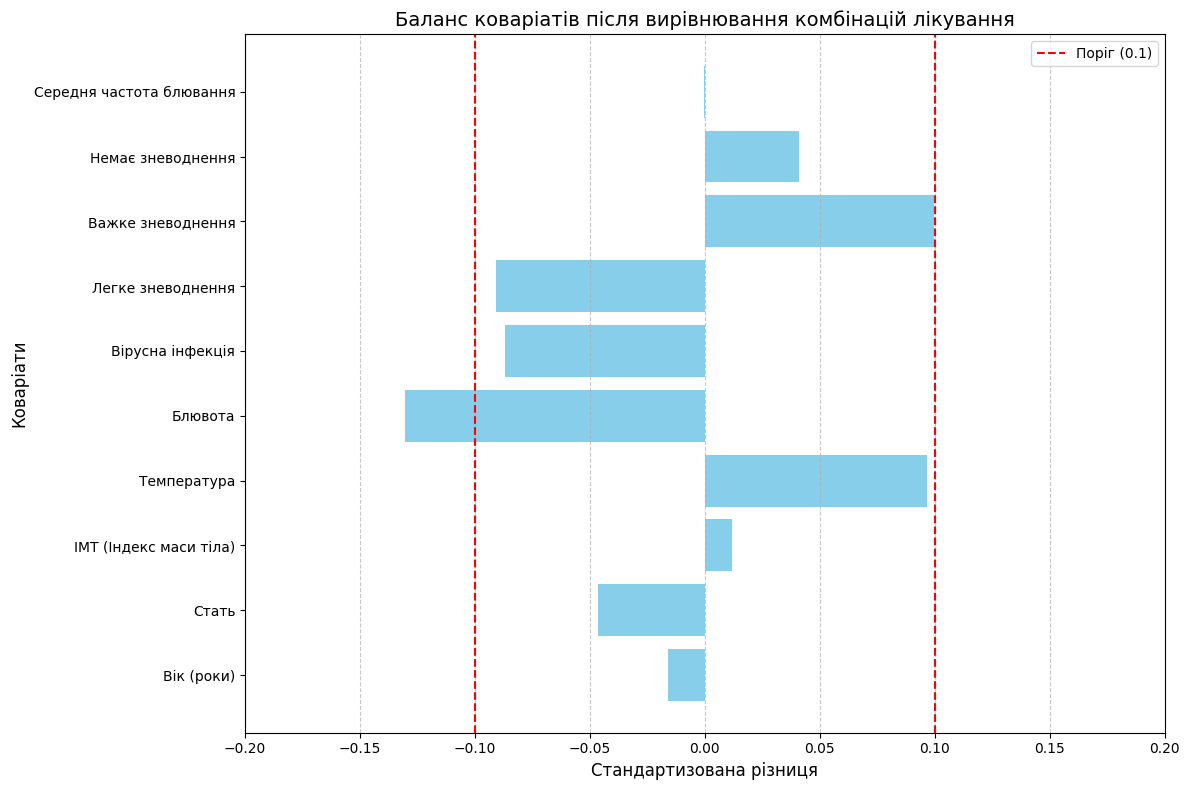

In [ ]:
# Переклад назв коваріатів на українську мову
balanced_covariate_balance['Covariate Ukrainian'] = balanced_covariate_balance['Covariate'].map(covariate_mapping_ukrainian)

# Візуалізація балансу коваріатів
plt.figure(figsize=(12, 8))

# Горизонтальна гістограма для балансу коваріатів
plt.barh(
    balanced_covariate_balance['Covariate Ukrainian'],  # Використовуємо перекладені назви
    balanced_covariate_balance['Standardized Difference'], 
    color='skyblue'
)

# Додаткові лінії порогу
plt.axvline(x=0.1, color='r', linestyle='--', label='Поріг (0.1)')
plt.axvline(x=-0.1, color='r', linestyle='--')

# Обмеження для осі X
plt.xlim(-0.2, 0.2)

# Додавання назв і підписів
plt.title('Баланс коваріатів після вирівнювання комбінацій лікування', fontsize=14)
plt.xlabel('Стандартизована різниця', fontsize=12)
plt.ylabel('Коваріати', fontsize=12)

# Додавання сітки та легенди
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.legend()
plt.show()


In [ ]:
balanced_subjects.drop(columns=['vomitfl'], inplace=True)


In [ ]:
balanced_subjects.columns

Index(['subjid', 'sex', 'temp', 'virusfl', 'hosp_days', 'age_years',
       'probioticfl', 'analgesicfl', 'antibioticfl', 'treatment_combination',
       'combination_description', 'dehsev_Mild_dehydration',
       'dehsev_No_dehydration', 'dehsev_Severe_dehydration', 'BMI',
       'vomit_avgfrq', 'binary_treatment', 'propensity_score',
       'treatment_status', 'controlfl'],
      dtype='object')

In [ ]:
# Calculate the median hospital stay
median_hosp_days = balanced_subjects['hosp_days'].median()
print(f"Median Hospital Stay: {median_hosp_days} days")


Median Hospital Stay: 4.0 days


In [ ]:
# Define the event status based on hospital stay
balanced_subjects['event_occurred'] = (balanced_subjects['hosp_days'] > median_hosp_days).astype(int)


In [ ]:
# Use hospital stay as the survival time
balanced_subjects['survival_time'] = balanced_subjects['hosp_days']


In [ ]:
balanced_subjects['survival_time']

0       3
1      12
2       3
3       5
4       5
       ..
515     4
516     6
517     8
518     4
519     6
Name: survival_time, Length: 520, dtype: int64

In [ ]:
balanced_subjects['treatment_combination'].unique()

array([  0,   1,  10, 100])

In [ ]:
balanced_subjects


,subjid,sex,temp,virusfl,hosp_days,age_years,probioticfl,analgesicfl,antibioticfl,treatment_combination,...,dehsev_No_dehydration,dehsev_Severe_dehydration,BMI,vomit_avgfrq,binary_treatment,propensity_score,treatment_status,controlfl,event_occurred,survival_time
0,480,2.0,38.4,0.0,3,1.597032,0,0,0,0,...,0.0,0.0,17.419074,9.500000,0,0.001174,Treated,0,0,3
1,764,1.0,36.8,1.0,12,0.433105,0,0,0,0,...,1.0,0.0,15.384615,4.296336,0,0.000549,Treated,0,1,12
2,289,2.0,37.3,1.0,3,0.788356,0,0,0,0,...,1.0,0.0,16.568047,4.500000,0,0.000630,Control,1,0,3
3,312,2.0,36.4,0.0,5,3.541096,0,0,0,0,...,0.0,0.0,16.966726,3.500000,0,0.000367,Treated,0,1,5
4,587,2.0,36.8,1.0,5,1.250000,0,0,0,0,...,0.0,0.0,16.326531,4.500000,0,0.001700,Control,1,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,602,1.0,36.1,0.0,4,1.000000,0,0,1,100,...,0.0,0.0,16.219723,4.296336,0,0.000389,Control,1,0,4
516,834,1.0,36.3,0.0,6,1.046575,0,0,1,100,...,1.0,0.0,16.326531,6.500000,0,0.000265,Control,1,1,6
517,325,1.0,38.0,0.0,8,0.718721,0,0,1,100,...,1.0,0.0,15.593673,2.500000,0,0.000820,Control,1,1,8
518,266,1.0,38.5,1.0,4,2.010959,0,0,1,100,...,0.0,1.0,13.887135,5.500000,0,0.002626,Control,1,0,4


In [ ]:
balanced_subjects.columns

Index(['subjid', 'sex', 'temp', 'virusfl', 'hosp_days', 'age_years',
       'probioticfl', 'analgesicfl', 'antibioticfl', 'treatment_combination',
       'combination_description', 'dehsev_Mild_dehydration',
       'dehsev_No_dehydration', 'dehsev_Severe_dehydration', 'BMI',
       'vomit_avgfrq', 'binary_treatment', 'propensity_score',
       'treatment_status', 'controlfl', 'event_occurred', 'survival_time'],
      dtype='object')

In [ ]:
balanced_subjects = balanced_subjects[balanced_subjects['antibioticfl'] == 0]

In [ ]:
len(balanced_subjects)

390

In [ ]:
# Step 2: Define covariates and necessary columns for Cox model
cox_covariates = [
 'sex', 'temp', 'virusfl',  'age_years',
 'dehsev_Mild_dehydration', 'dehsev_No_dehydration', 'dehsev_Severe_dehydration', 'BMI',
 'vomit_avgfrq',  'antibioticfl', 'analgesicfl', 'probioticfl', 'controlfl'
]

balanced_subjects

# Step 3: Ensure all covariates are numeric
bool_cols = balanced_subjects[cox_covariates].select_dtypes(include=['bool']).columns
balanced_subjects[bool_cols] = balanced_subjects[bool_cols].astype(int)

# Step 4: Include survival columns and stratification column
data_for_cox = balanced_subjects[
    cox_covariates + ['survival_time', 'event_occurred']
]

# Verify the structure of the new DataFrame
print("Columns in data_for_cox:\n", data_for_cox.columns)
print("First few rows:\n", data_for_cox.head())


Columns in data_for_cox:
 Index(['sex', 'temp', 'virusfl', 'age_years', 'dehsev_Mild_dehydration',
       'dehsev_No_dehydration', 'dehsev_Severe_dehydration', 'BMI',
       'vomit_avgfrq', 'antibioticfl', 'analgesicfl', 'probioticfl',
       'controlfl', 'survival_time', 'event_occurred'],
      dtype='object')
First few rows:
    sex  temp  virusfl  age_years  dehsev_Mild_dehydration  \
0  2.0  38.4      0.0   1.597032                      1.0   
1  1.0  36.8      1.0   0.433105                      0.0   
2  2.0  37.3      1.0   0.788356                      0.0   
3  2.0  36.4      0.0   3.541096                      1.0   
4  2.0  36.8      1.0   1.250000                      1.0   

   dehsev_No_dehydration  dehsev_Severe_dehydration        BMI  vomit_avgfrq  \
0                    0.0                        0.0  17.419074      9.500000   
1                    1.0                        0.0  15.384615      4.296336   
2                    1.0                        0.0  16.568047

In [ ]:
data_for_cox.columns

Index(['sex', 'temp', 'virusfl', 'age_years', 'dehsev_Mild_dehydration',
       'dehsev_No_dehydration', 'dehsev_Severe_dehydration', 'BMI',
       'vomit_avgfrq', 'antibioticfl', 'analgesicfl', 'probioticfl',
       'controlfl', 'survival_time', 'event_occurred'],
      dtype='object')

In [ ]:
from lifelines import CoxPHFitter

# Define covariates excluding treatment_combination_1
cox_covariates = [
  'temp',  'sex', 
'dehsev_Mild_dehydration', 'dehsev_Severe_dehydration', 
 'vomit_avgfrq',  'antibioticfl', 'analgesicfl', 'probioticfl', 'controlfl'
]

from lifelines import CoxPHFitter
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Step 1: Check VIF
X = data_for_cox[cox_covariates]
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)




                     feature        VIF
0                       temp  20.347216
1                        sex   9.190086
2    dehsev_Mild_dehydration   7.586458
3  dehsev_Severe_dehydration   1.337306
4               vomit_avgfrq   4.524180
5               antibioticfl        NaN
6                analgesicfl   2.242540
7                probioticfl   2.362046
8                  controlfl   2.855221


c:\Users\Danylo\AppData\Local\pypoetry\Cache\virtualenvs\lasting-analysis-7fXbj2Hf-py3.11\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


In [ ]:
data_for_cox

,sex,temp,virusfl,age_years,dehsev_Mild_dehydration,dehsev_No_dehydration,dehsev_Severe_dehydration,BMI,vomit_avgfrq,antibioticfl,analgesicfl,probioticfl,controlfl,survival_time,event_occurred
0,2.0,38.4,0.0,1.597032,1.0,0.0,0.0,17.419074,9.500000,0,0,0,0,3,0
1,1.0,36.8,1.0,0.433105,0.0,1.0,0.0,15.384615,4.296336,0,0,0,0,12,1
2,2.0,37.3,1.0,0.788356,0.0,1.0,0.0,16.568047,4.500000,0,0,0,1,3,0
3,2.0,36.4,0.0,3.541096,1.0,0.0,0.0,16.966726,3.500000,0,0,0,0,5,1
4,2.0,36.8,1.0,1.250000,1.0,0.0,0.0,16.326531,4.500000,0,0,0,1,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,1.0,36.3,1.0,2.868950,1.0,0.0,0.0,15.224913,2.000000,0,0,1,1,4,0
386,1.0,36.8,1.0,1.649087,1.0,0.0,0.0,15.363322,4.000000,0,0,1,1,2,0
387,1.0,37.1,0.0,3.102511,1.0,0.0,0.0,11.342155,6.500000,0,0,1,0,3,0
388,2.0,37.6,1.0,1.310274,1.0,0.0,0.0,18.750000,9.000000,0,0,1,1,4,0


In [ ]:
file_path = "data/data_for_cox.csv"
data_for_cox.to_csv(file_path, index=False)


In [ ]:
# Step 4: Fit Cox model with penalization
cox_model = CoxPHFitter(penalizer=0.1)  # Add regularization
cox_model.fit(
    data_for_cox[cox_covariates + ['survival_time', 'event_occurred']],
    duration_col='survival_time',
    event_col='event_occurred',
    strata=['antibioticfl']
)

<lifelines.CoxPHFitter: fitted with 390 total observations, 290 right-censored observations>


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...



c:\Users\Danylo\AppData\Local\pypoetry\Cache\virtualenvs\lasting-analysis-7fXbj2Hf-py3.11\Lib\site-packages\lifelines\utils\lowess.py:54: LinAlgWarning: Ill-conditioned matrix (rcond=6.91126e-17): result may not be accurate.
  beta = linalg.solve(A, b, assume_a="pos", check_finite=False)
c:\Users\Danylo\AppData\Local\pypoetry\Cache\virtualenvs\lasting-analysis-7fXbj2Hf-py3.11\Lib\site-packages\lifelines\utils\lowess.py:54: LinAlgWarning: Ill-conditioned matrix (rcond=2.89517e-17): result may not be accurate.
  beta = linalg.solve(A, b, assume_a="pos", check_finite=False)
c:\Users\Danylo\AppData\Local\pypoetry\Cache\virtualenvs\lasting-analysis-7fXbj2Hf-py3.11\Lib\site-packages\lifelines\utils\lowess.py:54: LinAlgWarning: Ill-conditioned matrix (rcond=4.25845e-17): result may not be accurate.
  beta = linalg.solve(A, b, assume_a="pos", check_finite=False)
c:\Users\Danylo\AppData\Local\pypoetry\Cache\virtualenvs\lasting-analysis-7fXbj2Hf-py3.11\Lib\site-packages\lifelines\utils\lowess.py


   Bootstrapping lowess lines. May take a moment...

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



c:\Users\Danylo\AppData\Local\pypoetry\Cache\virtualenvs\lasting-analysis-7fXbj2Hf-py3.11\Lib\site-packages\lifelines\utils\lowess.py:54: LinAlgWarning: Ill-conditioned matrix (rcond=6.69186e-17): result may not be accurate.
  beta = linalg.solve(A, b, assume_a="pos", check_finite=False)
c:\Users\Danylo\AppData\Local\pypoetry\Cache\virtualenvs\lasting-analysis-7fXbj2Hf-py3.11\Lib\site-packages\lifelines\utils\lowess.py:54: LinAlgWarning: Ill-conditioned matrix (rcond=4.39153e-17): result may not be accurate.
  beta = linalg.solve(A, b, assume_a="pos", check_finite=False)
c:\Users\Danylo\AppData\Local\pypoetry\Cache\virtualenvs\lasting-analysis-7fXbj2Hf-py3.11\Lib\site-packages\lifelines\utils\lowess.py:54: LinAlgWarning: Ill-conditioned matrix (rcond=2.89517e-17): result may not be accurate.
  beta = linalg.solve(A, b, assume_a="pos", check_finite=False)


<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 390 total observations, 290 right-censored observations>
         test_name = proportional_hazard_test

---
                                test_statistic      p  -log2(p)
analgesicfl               km              1.52   0.22      2.20
                          rank           11.58 <0.005     10.55
controlfl                 km              0.15   0.69      0.53
                          rank            1.15   0.28      1.81
dehsev_Mild_dehydration   km              4.11   0.04      4.55
                          rank            4.49   0.03      4.88
dehsev_Severe_dehydration km              0.17   0.68      0.56
                          rank            0.65   0.42      1.25
probioticfl               km              0.54   0.46      1.11
                          rank            3.74   0.05      4.24
sex                       km              0.01   0.91      0.14
                          rank            0.21   0.65      0.63
temp                      km              2.71   0.10      3.32
                          rank            2.07   0.15      2.74
vomit_avgfrq              km              0.86   0.35      1.50
                          rank            0.10   0.75      0.41



1. Variable 'dehsev_Mild_dehydration' failed the non-proportional test: p-value is 0.0340.

   Advice: with so few unique values (only 2), you can include `strata=['dehsev_Mild_dehydration',
...]` in the call in `.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...



c:\Users\Danylo\AppData\Local\pypoetry\Cache\virtualenvs\lasting-analysis-7fXbj2Hf-py3.11\Lib\site-packages\lifelines\utils\lowess.py:54: LinAlgWarning: Ill-conditioned matrix (rcond=4.25845e-17): result may not be accurate.
  beta = linalg.solve(A, b, assume_a="pos", check_finite=False)
c:\Users\Danylo\AppData\Local\pypoetry\Cache\virtualenvs\lasting-analysis-7fXbj2Hf-py3.11\Lib\site-packages\lifelines\utils\lowess.py:54: LinAlgWarning: Ill-conditioned matrix (rcond=6.91126e-17): result may not be accurate.
  beta = linalg.solve(A, b, assume_a="pos", check_finite=False)
c:\Users\Danylo\AppData\Local\pypoetry\Cache\virtualenvs\lasting-analysis-7fXbj2Hf-py3.11\Lib\site-packages\lifelines\utils\lowess.py:54: LinAlgWarning: Ill-conditioned matrix (rcond=9.69166e-17): result may not be accurate.
  beta = linalg.solve(A, b, assume_a="pos", check_finite=False)
c:\Users\Danylo\AppData\Local\pypoetry\Cache\virtualenvs\lasting-analysis-7fXbj2Hf-py3.11\Lib\site-packages\lifelines\utils\lowess.py


   Bootstrapping lowess lines. May take a moment...


2. Variable 'analgesicfl' failed the non-proportional test: p-value is 0.0007.

   Advice: with so few unique values (only 2), you can include `strata=['analgesicfl', ...]` in the
call in `.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...



c:\Users\Danylo\AppData\Local\pypoetry\Cache\virtualenvs\lasting-analysis-7fXbj2Hf-py3.11\Lib\site-packages\lifelines\utils\lowess.py:54: LinAlgWarning: Ill-conditioned matrix (rcond=6.69186e-17): result may not be accurate.
  beta = linalg.solve(A, b, assume_a="pos", check_finite=False)
c:\Users\Danylo\AppData\Local\pypoetry\Cache\virtualenvs\lasting-analysis-7fXbj2Hf-py3.11\Lib\site-packages\lifelines\utils\lowess.py:54: LinAlgWarning: Ill-conditioned matrix (rcond=7.07709e-17): result may not be accurate.
  beta = linalg.solve(A, b, assume_a="pos", check_finite=False)
c:\Users\Danylo\AppData\Local\pypoetry\Cache\virtualenvs\lasting-analysis-7fXbj2Hf-py3.11\Lib\site-packages\lifelines\utils\lowess.py:54: LinAlgWarning: Ill-conditioned matrix (rcond=6.91126e-17): result may not be accurate.
  beta = linalg.solve(A, b, assume_a="pos", check_finite=False)
c:\Users\Danylo\AppData\Local\pypoetry\Cache\virtualenvs\lasting-analysis-7fXbj2Hf-py3.11\Lib\site-packages\lifelines\utils\lowess.py


3. Variable 'probioticfl' failed the non-proportional test: p-value is 0.0530.

   Advice: with so few unique values (only 2), you can include `strata=['probioticfl', ...]` in the
call in `.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Introduce-time-varying-covariates
[D]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Modify-the-functional-form
[E]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Stratification



c:\Users\Danylo\AppData\Local\pypoetry\Cache\virtualenvs\lasting-analysis-7fXbj2Hf-py3.11\Lib\site-packages\lifelines\utils\lowess.py:54: LinAlgWarning: Ill-conditioned matrix (rcond=2.65149e-17): result may not be accurate.
  beta = linalg.solve(A, b, assume_a="pos", check_finite=False)


[[<Axes: xlabel='rank-transformed time\n(p=0.1501)'>,
  <Axes: xlabel='km-transformed time\n(p=0.1000)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.6470)'>,
  <Axes: xlabel='km-transformed time\n(p=0.9096)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0340)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0427)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.4196)'>,
  <Axes: xlabel='km-transformed time\n(p=0.6777)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.7526)'>,
  <Axes: xlabel='km-transformed time\n(p=0.3531)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0007)'>,
  <Axes: xlabel='km-transformed time\n(p=0.2182)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0530)'>,
  <Axes: xlabel='km-transformed time\n(p=0.4633)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.2844)'>,
  <Axes: xlabel='km-transformed time\n(p=0.6945)'>]]

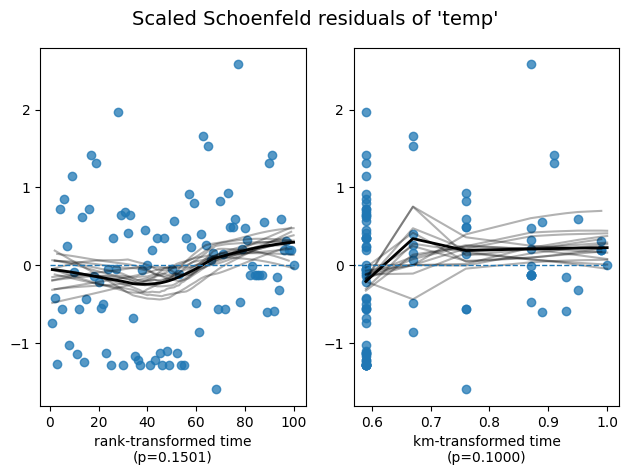

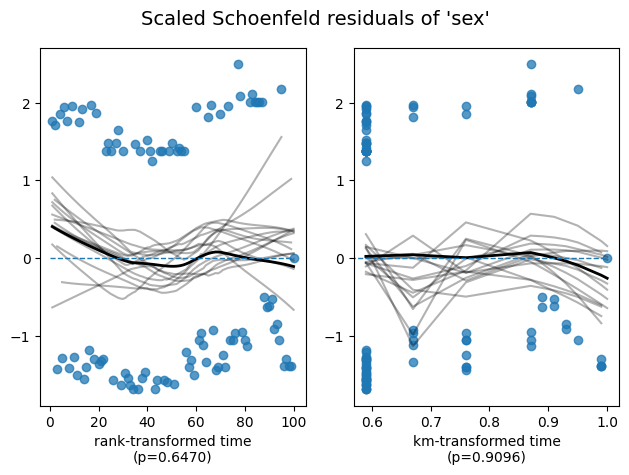

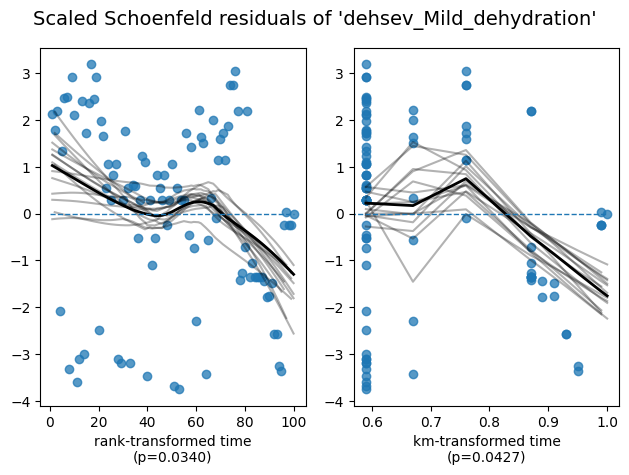

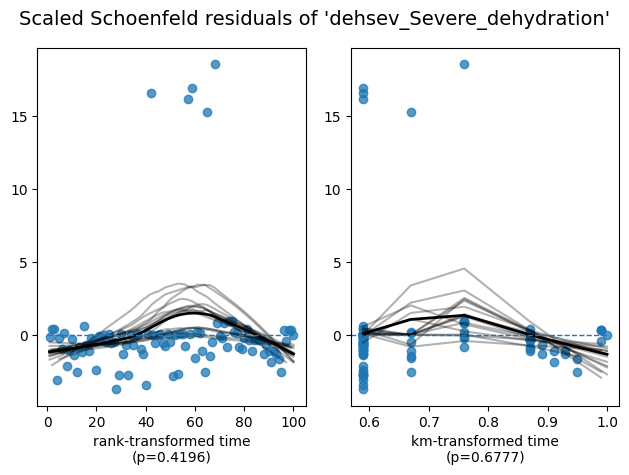

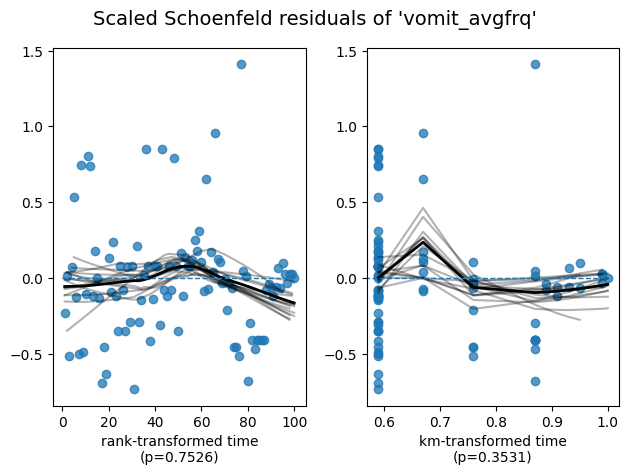

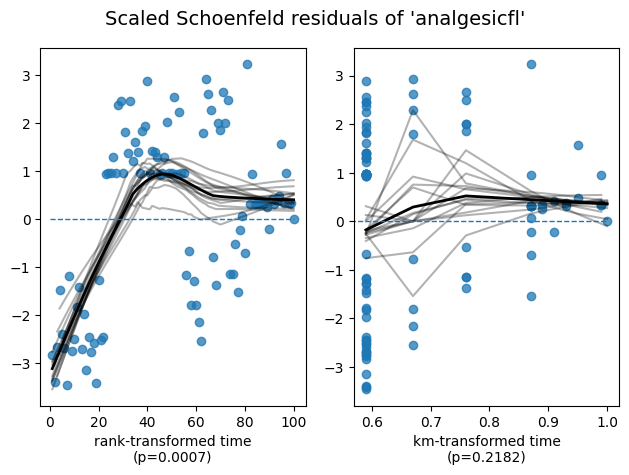

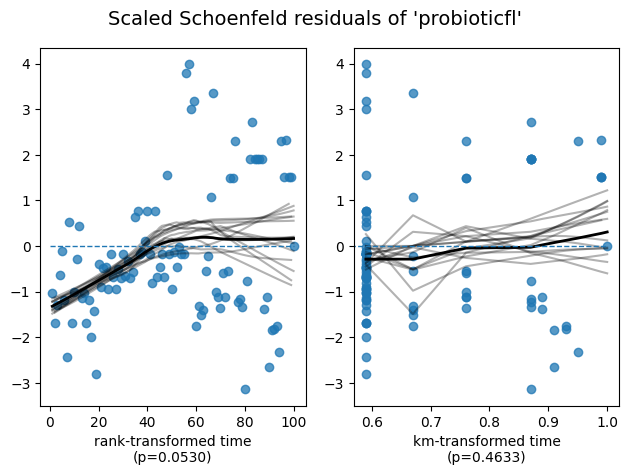

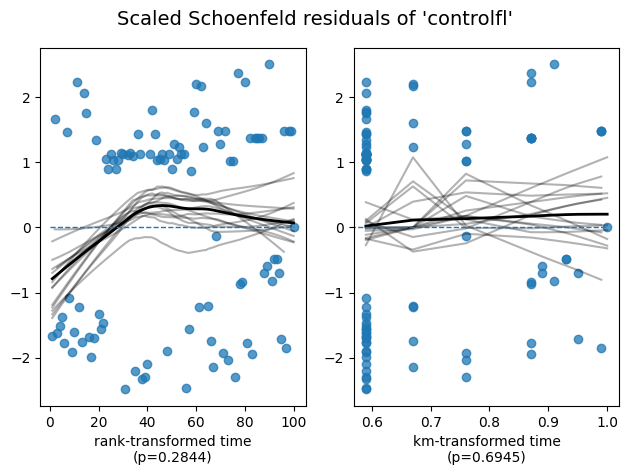

In [ ]:
cox_model.check_assumptions(data_for_cox[cox_covariates + ['survival_time', 'event_occurred']], show_plots=True, p_value_threshold=0.05)


In [ ]:
cox_summary = cox_model.summary

In [ ]:
cox_summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
temp,-0.124010,0.883371,0.107656,-0.335011,0.086992,0.715330,1.090888,0.0,-1.151908,0.249359,2.003706
sex,0.135448,1.145050,0.176975,-0.211416,0.482312,0.809437,1.619816,0.0,0.765353,0.444062,1.171168
dehsev_Mild_dehydration,0.241706,1.273420,0.214789,-0.179272,0.662684,0.835878,1.939993,0.0,1.125320,0.260453,1.940903
dehsev_Severe_dehydration,0.488881,1.630491,0.443082,-0.379542,1.357305,0.684174,3.885709,0.0,1.103367,0.269868,1.889674
vomit_avgfrq,-0.026401,0.973944,0.044343,-0.113312,0.060510,0.892872,1.062378,0.0,-0.595378,0.551591,0.858330
analgesicfl,0.452786,1.572687,0.210218,0.040767,0.864805,1.041609,2.374543,0.0,2.153891,0.031249,5.000059
probioticfl,-0.497528,0.608032,0.222704,-0.934020,-0.061035,0.392971,0.940790,0.0,-2.234026,0.025481,5.294415
controlfl,0.207518,1.230620,0.182484,-0.150144,0.565180,0.860584,1.759765,0.0,1.137185,0.255461,1.968826


In [ ]:
# Define the FL variables
fl_variables = ['analgesicfl', 'probioticfl', 'controlfl']

# Extract treatment effects for FL variables
treatment_effects = cox_summary.loc[
    fl_variables,
    ['coef', 'exp(coef)', 'p']
]

# Rename columns for better readability
treatment_effects = treatment_effects.rename(columns={'exp(coef)': 'Hazard Ratio'})

# Print treatment effects
print("\nTreatment Effects (Hazard Ratios):")
print(treatment_effects)



Treatment Effects (Hazard Ratios):
                 coef  Hazard Ratio         p
covariate                                    
analgesicfl  0.452786      1.572687  0.031249
probioticfl -0.497528      0.608032  0.025481
controlfl    0.207518      1.230620  0.255461


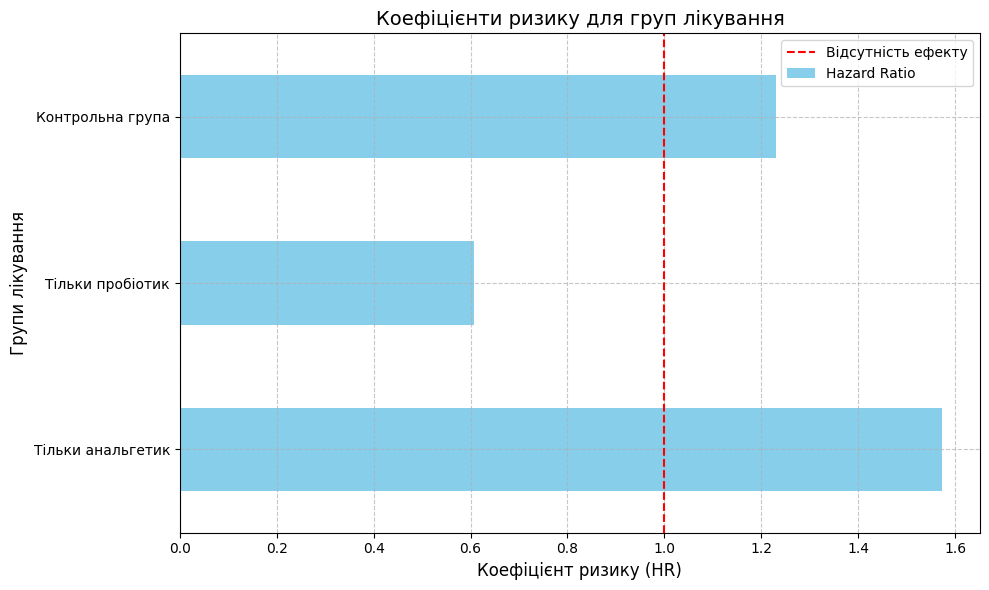

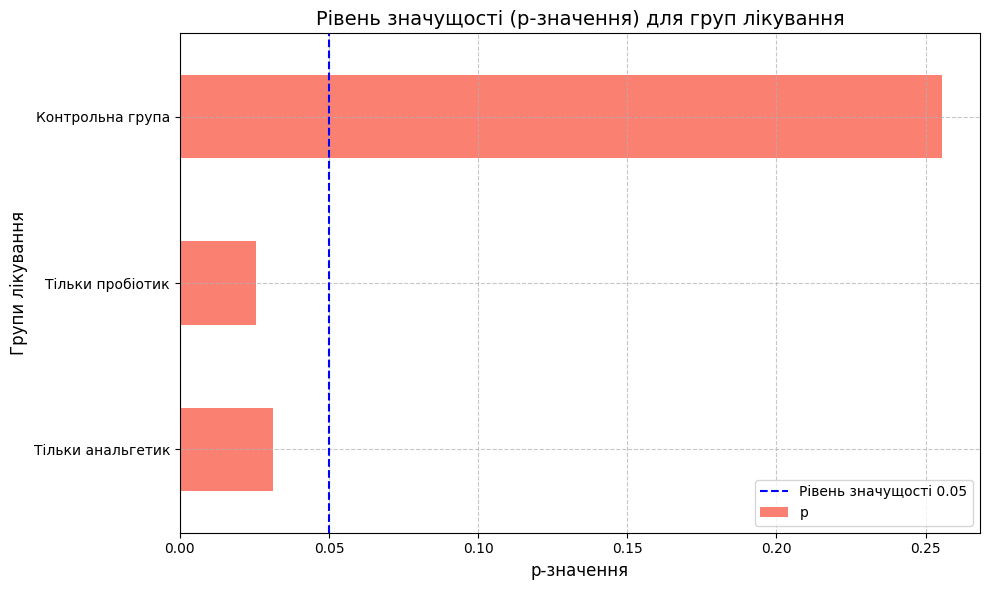

In [ ]:
import matplotlib.pyplot as plt

# Define the mapping for Ukrainian treatment names
treatment_mapping_ukrainian = {
    "antibioticfl": "Тільки антибіотик",
    "analgesicfl": "Тільки анальгетик",
    "probioticfl": "Тільки пробіотик",
    "controlfl": "Контрольна група"
}

# Ensure 'Hazard Ratio' is available
cox_summary = cox_summary.rename(columns={'exp(coef)': 'Hazard Ratio'})

# Filter treatment coefficients (FL variables)
available_treatment_covariates = ['antibioticfl', 'analgesicfl', 'probioticfl', 'controlfl']
available_treatment_covariates = [var for var in available_treatment_covariates if var in cox_summary.index]

# Check if there are any available covariates
if not available_treatment_covariates:
    raise ValueError("No treatment covariates found in the Cox model summary.")

# Filter the summary for the available covariates
treatment_effects = cox_summary.loc[available_treatment_covariates, ['coef', 'Hazard Ratio', 'p']]

# Translate the treatment labels into Ukrainian
treatment_effects['Ukrainian Label'] = [
    treatment_mapping_ukrainian.get(col, col) for col in available_treatment_covariates
]

# Plot Hazard Ratios with Ukrainian Labels
fig, ax = plt.subplots(figsize=(10, 6))
treatment_effects.set_index('Ukrainian Label')['Hazard Ratio'].plot(kind='barh', ax=ax, legend=False, color='skyblue')
plt.title('Коефіцієнти ризику для груп лікування', fontsize=14)
plt.xlabel('Коефіцієнт ризику (HR)', fontsize=12)
plt.ylabel('Групи лікування', fontsize=12)
plt.axvline(x=1, color='red', linestyle='--', label='Відсутність ефекту')
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot p-values with Ukrainian Labels
fig, ax = plt.subplots(figsize=(10, 6))
treatment_effects.set_index('Ukrainian Label')['p'].plot(kind='barh', ax=ax, legend=False, color='salmon')
plt.title('Рівень значущості (p-значення) для груп лікування', fontsize=14)
plt.xlabel('p-значення', fontsize=12)
plt.ylabel('Групи лікування', fontsize=12)
plt.axvline(x=0.05, color='blue', linestyle='--', label='Рівень значущості 0.05')
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
